# This notebook demonstrates how to use kepler_kinematics to calculate stellar velocities

In [2]:
%matplotlib inline

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.io import fits
import pymc3 as pm

import corner

import kepler_kinematics as kek

Let's load the Gaia-Kepler crossmatched catalog.

In [115]:
with fits.open("../../data/kepler_dr2_1arcsec.fits") as data:
    gaia = pd.DataFrame(data[1].data, dtype="float64")
gaia_rv = gaia.iloc[gaia.radial_velocity.values != 0.]

In [116]:
# df = pd.read_csv("../kepler_kinematics/data.csv")
# gaia_rv = df.iloc[np.isfinite(df.rv.values)]

Select a star.

In [117]:
np.random.seed(1)
star_index = np.random.randint(0, len(gaia_rv))
print(star_index)
df = gaia_rv.iloc[star_index]
print(int(df.kepid))

29733
12218729


First, let's calculate the 3D velocities of the star using its radial velocity.

In [118]:
# for i, row in enumerate(df):
xyz, vxyz = kek.simple_calc_vxyz(df["ra"], df["dec"],
#                                  df["r_med_photogeo"]*1e-3,
                                 df["r_est"]*1e-3,
                                 df["pmra"], df["pmdec"],
                                 df["radial_velocity"])
#                                  df["rv"])


vx, vy, vz = vxyz
x, y, z = xyz
# d = df["r_med_photogeo"] * 1e-3
d = df["r_est"] * 1e-3

Now let's infer the 3D velocities of the star. First we'll create arrays of position, parallax, and proper motion.

In [119]:
pos = [float(df["ra"]), float(df["dec"]), float(df["parallax"])]
pos_err = [float(df["ra_error"]), float(df["dec_error"]),
           float(df["parallax_error"])]
proper = [float(df["pmra"]), float(df["pmdec"])]
proper_err = [float(df["pmra_error"]), float(df["pmdec_error"])]

Get the prior that's built-in for Kepler stars.

In [120]:
mu, cov = kek.get_prior()

Run the velocity inference code.

In [121]:
trace = kek.run_pymc3_model(pos, pos_err, proper, proper_err, mu, cov)

optimizing logp for variables: [vxyzD]


message: Optimization terminated successfully.
logp: -2139.8073386855817 -> -10.535049056406335


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vxyzD]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 22 seconds.


Pull out the results from the samples.

In [122]:
import arviz as az

az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
vxyzD[0],31.472,2.629,26.762,36.590,0.040,0.028,4379.0,4379.0,4387.0,3148.0,1.0
vxyzD[1],229.966,24.451,185.307,276.964,0.370,0.262,4366.0,4366.0,4373.0,2943.0,1.0
vxyzD[2],1.062,5.535,-9.377,11.403,0.084,0.083,4344.0,2209.0,4349.0,2952.0,1.0
vxyzD[3],-1.035,0.027,-1.088,-0.987,0.000,0.000,4144.0,4144.0,4094.0,3082.0,1.0
vxyz[0],31.472,2.629,26.762,36.590,0.040,0.028,4379.0,4379.0,4387.0,3148.0,1.0
vxyz[1],229.966,24.451,185.307,276.964,0.370,0.262,4366.0,4366.0,4373.0,2943.0,1.0
vxyz[2],1.062,5.535,-9.377,11.403,0.084,0.083,4344.0,2209.0,4349.0,2952.0,1.0
log_D,-1.035,0.027,-1.088,-0.987,0.000,0.000,4144.0,4144.0,4094.0,3082.0,1.0
D,0.355,0.010,0.337,0.373,0.000,0.000,4126.0,4105.0,4094.0,3082.0,1.0
xyz[0],-8.086,0.001,-8.088,-8.084,0.000,0.000,4126.0,4126.0,4094.0,3082.0,1.0


In [123]:
# trace.posterior.to_dataframe()
print(np.median(trace.posterior["D"].values))
print(np.median(trace.posterior["vxyz"].values, axis=(0, 1)))

0.3547371766931454
[ 31.48742865 230.16635082   1.13174956]


In [124]:
print(np.shape(trace.posterior["vxyzD"].values))
vsamples = np.reshape(trace.posterior["vxyzD"].values, (4000, 4))
print(np.shape(vsamples))

(4, 1000, 4)
(4000, 4)


In [125]:
print(np.shape(np.cov(vsamples.T)))
print((np.cov(vsamples.T)))
cov_mat = np.cov(vsamples.T)
vxvx_covar, vxvy_covar, vxvz_covar, vxlnd_covar = cov_mat[:, 0]
vyvx_covar, vyvy_covar, vyvz_covar, vylnd_covar = cov_mat[:, 1]
vzvx_covar, vzvy_covar, vzvz_covar, vzlnd_covar = cov_mat[:, 2]
lndvx_covar, lndvy_covar, lndvz_covar, lndlnd_covar = cov_mat[:, 3]

print(vxvx_covar, vxvy_covar, vxvz_covar, vxlnd_covar,
      vyvy_covar, vyvz_covar, vylnd_covar,
      vzvz_covar, vzlnd_covar,
      lndlnd_covar)

(4, 4)
[[ 6.91186517e+00  6.27004102e+01  1.41353560e+01  1.36762184e-02]
 [ 6.27004102e+01  5.97844463e+02  1.35206565e+02 -9.21520402e-03]
 [ 1.41353560e+01  1.35206565e+02  3.06338625e+01 -4.47271275e-03]
 [ 1.36762184e-02 -9.21520402e-03 -4.47271275e-03  7.22738391e-04]]
6.911865166635117 62.70041024899207 14.135356048370603 0.013676218356722338 597.8444631150294 135.20656487998923 -0.009215204023260218 30.633862524962293 -0.004472712750943953 0.0007227383912155148


In [126]:
a = np.linspace(0, 10, 10)
print(np.shape(np.vstack((a, a))))

(2, 10)


12218729


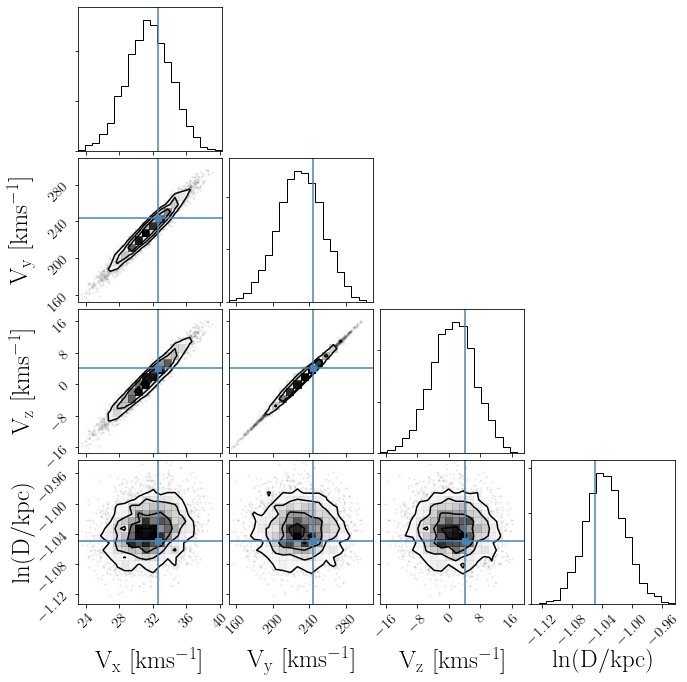

In [131]:
plotpar = {'axes.labelsize': 25,
           'font.size': 12,
           'legend.fontsize': 15,
           'xtick.labelsize': 15,
           'ytick.labelsize': 15,
           'text.usetex': True}
plt.rcParams.update(plotpar)

labels = ["$\mathrm{V_x~[kms^{-1}]}$", "$\mathrm{V_y~[kms^{-1}]}$", "$\mathrm{V_z~[kms^{-1}]}$",
          "$\mathrm{\ln(D/kpc)}$"]
fig = corner.corner(vsamples, labels=labels, truths=[vx.value, vy.value, vz.value, np.log(d)], dpi=200);
# plt.title(f"KIC {format(int(df.kepid))}")
plt.savefig("../plots/posterior")
plt.savefig("../paper/posterior.pdf")
print(int(df.kepid))

In [132]:
d

0.35024166612533003

In [10]:
flat_samples = pm.trace_to_dataframe(trace)

params_inferred = np.median(flat_samples, axis=0)
upper = np.percentile(flat_samples, 84, axis=0)
lower = np.percentile(flat_samples, 16, axis=0)
errp = upper - params_inferred
errm = params_inferred - lower
std = np.std(flat_samples, axis=0)

results = pd.DataFrame(dict({"kepid": df["kepid"],
                             "vx": params_inferred[0], "vx_errp": errp[0], "vx_errm": errm[0], "vx_err": std[0],
                             "vy": params_inferred[1], "vy_errp": errp[1], "vy_errm": errm[1], "vy_err": std[1],
                             "vz": params_inferred[2], "vz_errp": errp[2], "vz_errm": errm[2], "vz_err": std[2],
                             "lndistance": params_inferred[3], "lndistance_errp": errp[3],
                             "lndistance_errm": errm[3], "lndistance_err": std[3]
                            }), index=[0])

In [11]:
print(f"{vx:.1f}, {float(results.vx.values):.1f} +/- {float(results.vx_err.values):.1f} km / s")
print(f"{vy:.1f}, {float(results.vy.values):.1f} +/- {float(results.vy_err.values):.1f} km / s")
print(f"{vz:.1f}, {float(results.vz.values):.1f} +/- {float(results.vz_err.values):.1f} km / s")

50.4 km / s, 52.8 +/- 8.7 km / s
215.2 km / s, 220.7 +/- 22.7 km / s
-0.3 km / s, 0.7 +/- 4.2 km / s


In [12]:
print(f"{vx:.1f}, {float(results.vx.values):.1f} +/- {float(results.vx_err.values):.1f} km / s")
print(f"{vy:.1f}, {float(results.vy.values):.1f} +/- {float(results.vy_err.values):.1f} km / s")
print(f"{vz:.1f}, {float(results.vz.values):.1f} +/- {float(results.vz_err.values):.1f} km / s")

50.4 km / s, 52.8 +/- 8.7 km / s
215.2 km / s, 220.7 +/- 22.7 km / s
-0.3 km / s, 0.7 +/- 4.2 km / s


# Test with the new data file.

In [133]:
df = pd.read_csv("../kepler_kinematics/data.csv")
gaia_rv = df.iloc[np.isfinite(df.rv.values)]

In [134]:
df = gaia_rv.iloc[0]
print(int(df.kepid))

8571171


In [135]:
xyz, vxyz = kek.simple_calc_vxyz(df["ra"], df["dec"],
                                 df["r_med_photogeo"]*1e-3,
                                 df["pmra"], df["pmdec"],
                                 df["rv"])

vx, vy, vz = vxyz
x, y, z = xyz
d = df["r_med_photogeo"] * 1e-3

In [136]:
pos = [float(df["ra"]), float(df["dec"]), float(df["parallax"])]
pos_err = [float(df["ra_error"]), float(df["dec_error"]),
           float(df["parallax_error"])]
proper = [float(df["pmra"]), float(df["pmdec"])]
proper_err = [float(df["pmra_error"]), float(df["pmdec_error"])]

In [137]:
mu, cov = kek.get_prior()

In [138]:
trace = kek.run_pymc3_model(pos, pos_err, proper, proper_err, mu, cov)

optimizing logp for variables: [vxyzD]


message: Optimization terminated successfully.
logp: -17352.812713213676 -> -6.565973256237763


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vxyzD]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 26 seconds.


Text(0.5, 1.0, 'KIC 8571171')

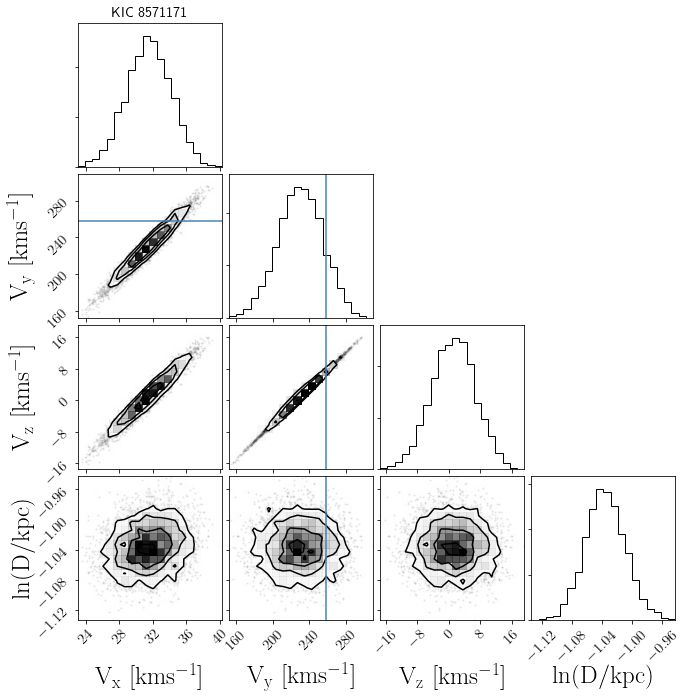

In [147]:
plotpar = {'axes.labelsize': 25,
           'font.size': 12,
           'legend.fontsize': 15,
           'xtick.labelsize': 15,
           'ytick.labelsize': 15,
           'text.usetex': True}
plt.rcParams.update(plotpar)

labels = ["$\mathrm{V_x~[kms^{-1}]}$", "$\mathrm{V_y~[kms^{-1}]}$", "$\mathrm{V_z~[kms^{-1}]}$",
          "$\mathrm{\ln(D/kpc)}$"]
fig = corner.corner(vsamples, labels=labels, truths=[df.vx, df.vy, df.vz,
                                                     np.log(df.r_med_photogeo*1e-3)], dpi=200);

axes = np.array(fig.axes).reshape((4, 4))
ax = axes[0, 0]
ax.set_title(f"KIC {format(int(df.kepid))}")

In [149]:
df.vx, df.vy, df.vz, np.log(df.r_med_photogeo*1e-3)

(72.50820646712964, 257.5916489987804, -30.44791289258149, 1.0332973377146828)

In [153]:
res = pd.read_csv("../data/edr3_all.csv")
np.array([k for k in res.keys()])
resdat = pd.merge(res, gaia_rv, on="kepid")

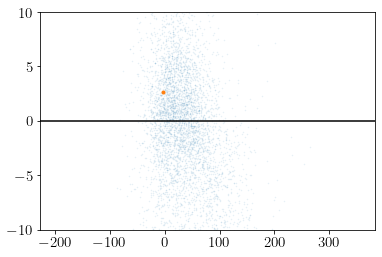

In [159]:
plt.plot(resdat.vx_inferred, resdat.vx-resdat.vx_inferred, ".", alpha=.1, ms=1)
plt.plot(resdat.vx_inferred[0], resdat.vx[0]-resdat.vx_inferred[0], ".")
plt.ylim(-10, 10)
plt.axhline(0, color="k")